In [1]:
# Import dependencies
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
# Read data
game_results_all = pd.read_csv('https://storage.googleapis.com/big-data-bowl/game-results-all.csv', encoding='latin')
season_stats_offense = pd.read_csv('https://storage.googleapis.com/big-data-bowl/season-stats-offense.csv', encoding='latin')
season_stats_defense = pd.read_csv('https://storage.googleapis.com/big-data-bowl/season-stats-defense.csv', encoding='latin')

games = pd.read_csv('https://storage.googleapis.com/big-data-bowl/games.csv')

In [3]:
# Define team abbreviations
stats_team_abbr_dict = {
    'TB': 'Tampa Bay Buccaneers',
    'ATL': 'Atlanta Falcons',
    'BUF': 'Buffalo Bills',
    'CAR': 'Carolina Panthers',
    'CIN': 'Cincinnati Bengals',
    'DET': 'Detroit Lions',
    'HOU': 'Houston Texans',
    'IND': 'Indianapolis Colts',
    'TEN': 'Tennessee Titans',
    'WAS': 'Washington Redskins',
    'KC': 'Kansas City Chiefs',
    'NE': 'New England Patriots',
    'NO': 'New Orleans Saints',
    'NYG': 'New York Giants',
    'LA': 'Los Angeles Rams',
    'LV': 'Oakland Raiders',
    'CHI': 'Chicago Bears',
    'CLE': 'Cleveland Browns',
    'JAX': 'Jacksonville Jaguars',
    'MIA': 'Miami Dolphins',
    'NYJ': 'New York Jets',
    'PHI': 'Philadelphia Eagles',
    'PIT': 'Pittsburgh Steelers',
    'ARI': 'Arizona Cardinals',
    'LAC': 'Los Angeles Chargers',
    'SEA': 'Seattle Seahawks',
    'BAL': 'Baltimore Ravens',
    'GB': 'Green Bay Packers',
    'DEN': 'Denver Broncos',
    'MIN': 'Minnesota Vikings',
    'SF': 'San Francisco 49ers',
    'DAL': 'Dallas Cowboys'
}


In [4]:
# Clean team columns for matchup prediction DataFrame
matchups = games.copy()
games['homeTeam'] = games['homeTeamAbbr'].apply(lambda x: stats_team_abbr_dict[x])
games['visitorTeam'] = games['visitorTeamAbbr'].apply(lambda x: stats_team_abbr_dict[x])

matchups = games[['homeTeam', 'visitorTeam']]

In [5]:
# Clean season stats
season_stats = season_stats_offense.merge(
    season_stats_defense,
    on='Team',
    suffixes=('_offense', '_defense')
)

season_stats.rename(columns={'Season_offense': 'Season'}, inplace=True)
season_stats['Next Season'] = season_stats['Season'] + 1
season_stats.drop(['Season_defense', 'Season'], axis=1, inplace=True)
season_stats = season_stats.groupby(['Next Season', 'Team']).first().reset_index()

In [6]:
# Create training data
training_data = game_results_all.merge(
    season_stats,
    left_on=['Home', 'Season'],
    right_on=['Team', 'Next Season']
)

training_data = training_data.merge(
    season_stats,
    left_on=['Visitor', 'Season'],
    right_on=['Team', 'Next Season'],
    suffixes=('_home', '_visitor')
)

training_data.drop(['Visitor', 'Home', 'Team_visitor', 'Team_home'], axis=1, inplace=True)

In [7]:
games

,gameId,season,week,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr,homeTeam,visitorTeam
0,2021090900,2021,1,09/09/2021,20:20:00,TB,DAL,Tampa Bay Buccaneers,Dallas Cowboys
1,2021091200,2021,1,09/12/2021,13:00:00,ATL,PHI,Atlanta Falcons,Philadelphia Eagles
2,2021091201,2021,1,09/12/2021,13:00:00,BUF,PIT,Buffalo Bills,Pittsburgh Steelers
3,2021091202,2021,1,09/12/2021,13:00:00,CAR,NYJ,Carolina Panthers,New York Jets
4,2021091203,2021,1,09/12/2021,13:00:00,CIN,MIN,Cincinnati Bengals,Minnesota Vikings
...,...,...,...,...,...,...,...,...,...
117,2021103109,2021,8,10/31/2021,16:05:00,SEA,JAX,Seattle Seahawks,Jacksonville Jaguars
118,2021103110,2021,8,10/31/2021,16:25:00,DEN,WAS,Denver Broncos,Washington Redskins
119,2021103111,2021,8,10/31/2021,16:25:00,NO,TB,New Orleans Saints,Tampa Bay Buccaneers
120,2021103112,2021,8,10/31/2021,20:20:00,MIN,DAL,Minnesota Vikings,Dallas Cowboys


In [8]:
# Create prediction data
prediction_data = games[['homeTeam', 'visitorTeam', 'season']].copy()

prediction_data = prediction_data.merge(
    season_stats,
    left_on=['homeTeam', 'season'],
    right_on=['Team', 'Next Season'],
    how='left'
)

prediction_data = prediction_data.merge(
    season_stats,
    left_on=['visitorTeam', 'season'],
    right_on=['Team', 'Next Season'],
    suffixes=('_home', '_visitor'),
    how='left'
)

prediction_data.drop(['visitorTeam', 'homeTeam'], axis=1, inplace=True)
prediction_data.dropna(inplace=True)

In [9]:
# Create home model
X_home = training_data.drop(['Visitor Score', 'Home Score', 'Season'], axis=1)
y_home = training_data['Home Score']

home_model = LinearRegression()
home_model.fit(X_home, y_home)

score = home_model.score(X_home, y_home)
print(f"R2 Score: {score}")

R2 Score: 0.0821783182252197


In [10]:
# Create visitor model
X_visitor = training_data.drop(['Visitor Score', 'Home Score', 'Season'], axis=1)
y_visitor = training_data['Visitor Score']

visitor_model = LinearRegression()
visitor_model.fit(X_visitor, y_visitor)

score = visitor_model.score(X_visitor, y_visitor)
print(f"R2 Score: {score}")

R2 Score: 0.06956674115000627


In [11]:
# Predict 2021 scores
home_predictions = home_model.predict(prediction_data.drop(['Team_visitor', 'Team_home', 'season'], axis=1))
visitor_predictions = visitor_model.predict(prediction_data.drop(['Team_visitor', 'Team_home', 'season'], axis=1))

predicted_data = prediction_data.copy()

predicted_data['predictedHomeScore'] = home_predictions
predicted_data['predictedVisitorScore'] = visitor_predictions

predicted_data['homeWin'] = predicted_data.apply(lambda r: r['predictedHomeScore'] - r['predictedVisitorScore'] > 1, axis=1)

In [12]:
game_results_2021 = game_results_all[game_results_all['Season'] == 2021]
game_results_2021['homeWin'] = game_results_2021.apply(lambda r: r['Home Score'] - r['Visitor Score'] > 1, axis=1)

C:\Users\lself\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [13]:
prediction_results = predicted_data.merge(
    game_results_2021,
    left_on=['Team_home', 'Team_visitor'],
    right_on=['Home', 'Visitor'],
    suffixes=('_pred', '_actual')
)

prediction_results['correct'] = prediction_results.apply(lambda r: int(r['homeWin_pred'] == r['homeWin_actual']), axis=1)
predicted_scores = prediction_results[['Visitor', 'Home', 'predictedHomeScore', 'predictedVisitorScore', 'correct']]
prediction_results = prediction_results[['Visitor', 'Home', 'homeWin_pred', 'homeWin_actual', 'correct']]

prediction_results['correct'].mean()

0.7570093457943925

In [14]:
predicted_scores['Margin'] = predicted_scores.apply(lambda r: r['predictedHomeScore'] - r['predictedVisitorScore'], axis=1)

In [15]:
predicted_scores

,Visitor,Home,predictedHomeScore,predictedVisitorScore,correct,Margin
0,Dallas Cowboys,Tampa Bay Buccaneers,28.556885,21.791321,1,6.765564
1,Philadelphia Eagles,Atlanta Falcons,23.187012,24.405151,1,-1.218140
2,Pittsburgh Steelers,Buffalo Bills,26.573730,22.913635,0,3.660095
3,New York Jets,Carolina Panthers,24.495605,21.033020,1,3.462585
4,Minnesota Vikings,Cincinnati Bengals,19.457031,24.737671,0,-5.280640
...,...,...,...,...,...,...
102,New England Patriots,Los Angeles Chargers,22.805908,23.989624,1,-1.183716
103,Jacksonville Jaguars,Seattle Seahawks,26.549805,21.594971,1,4.954834
104,Tampa Bay Buccaneers,New Orleans Saints,26.009033,24.872803,1,1.136230
105,Dallas Cowboys,Minnesota Vikings,25.900635,22.283508,0,3.617126


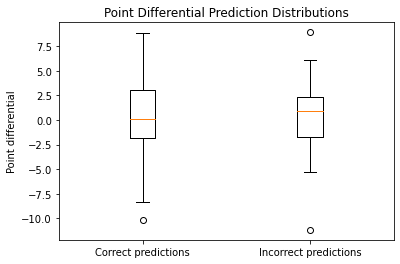

In [32]:
#MultipleBoxplot
plt.boxplot([predicted_scores['Margin'][predicted_scores['correct'] == 1], predicted_scores['Margin'][predicted_scores['correct'] == 0]]) 
plt.ylabel('Point differential')
plt.xticks([1, 2], ['Correct predictions', 'Incorrect predictions'])
plt.title('Point Differential Prediction Distributions')
plt.show()